# Model NEATM 余亮亮 修改 $\alpha, \phi$
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\alpha+\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$


# MCMC_NEATM
## import & define const

In [40]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 

#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 20
G = 0.15
Ndd = 10
lamdai = [12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model_hhq

In [41]:
def neatm_hhq(Ndd,eta,D,delta,d,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = mh.pow((1-A)*Fsun/(eta*epsi*sigma*d*d),0.25,)
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*mh.pow(mh.cos(thei),0.25)*mh.pow(mh.cos(phii),0.25)
            integral = mh.cos(alpha)**2*mh.cos(alpha-thei)/(mh.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    #print('hhq',delta)
    F = (epsi*mh.pow(D,2)*pi*h*cl*cl)*summ/(2*mh.pow(delta,2)*mh.pow(lamda,5))

    F = F*(lamda*1e-6)**2/cl*1e29 
    #print('hhq2',delta)
    return F
def Model_neatm_hhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_hhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_hhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2,A)
        #print("neatm",i,'=',delta[i])
    #print('2',delta)
    return flux

### Model_jhx

In [42]:
#constants---------------------------------------------------------------------------
#emissivity:
epsi = 0.9
#stefan-boltzman:
sigmas = 5.67*10**(-8)
#solar constant:
f_solar = 1367.5
#planck constant:
h = 6.62607015 * 10 ** (-34)
#speed of light
c = 3.0 * 10 ** 8 
#boltzmann constant
kb = 1.380649 * 10 ** (-23)
#astronomical unit in unit of meter
au = 1.496 * 10 ** 11
def neatm_jhx(Ndd,dast,dao,alpha,Dia,wlenth,yita,A):
    #dast: distance from asteroid to Sun :d
    #dobs: distance from observer to Sun  :dd
    #dao:  distance from asteroid to observer :delta
    #alpha: solar phase
    #dia: diameter of asteroid
    #wlenth: wavelength
    #yita: beaming parameter
    #A: bond albedo
	
	T_ss = ((1 - A) * f_solar / epsi / yita / sigmas / dast ** 2) ** 0.25
	Nd = int(Ndd);#print(f'nd={Nd}')
	phi = np.zeros((Nd-1,1))
	theta = np.zeros((Nd-1,1))
	for i in range(0,Nd-1):#phi , theta is the angle from subsolar point
			phi[i] = -pi/2.0 + i * pi / Nd
			theta[i] = alpha-pi/2.0 + i * pi / Nd
	#nj = np.floor(((alpha - pi / 2.0) + pi / 2.0) / (pi / Nd)) 
	dphi, dtheta = (pi)/Nd,pi/Nd;#print(f'phi={phi};the={theta}')
	ss = dphi*dtheta;#print(f'ss={ss}')#dtheta*dphi
	wlenth = wlenth * 10 ** (-6)
	temp = np.zeros((len(phi),len(theta)))
	flux = 0.0
	flux_con = epsi * Dia ** 2 * pi  * h * c ** 2  / (wlenth ** 5)
	for j in range(0,len(phi)):
		for k in range(0,len(theta)):
			temp[j,k] = T_ss * abs(np.cos(theta[k])) ** 0.25 * abs(np.cos(phi[j])) ** 0.25;#print(f'tss:{T_ss}p{phi[j]}t{theta[k]}');print(f'temp:{temp[j,k]}e={np.exp(h * c / (wlenth * kb * temp[j,k])) - 1}')
			flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy
	return flux
def Model_neatm_jhx(theta,x,lamda):
    eta,D =theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    nn = len(delta)
    flux = np.zeros(nn)
    for i in range(0,int(nn/2)):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda1,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/2),nn):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda2,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
        
    #print('hello',flux)
    return flux

## read data file

[ 5.02243672  5.049271    5.05923835  5.05943601  5.06519005  5.08111633
  5.08375878  5.10814155  5.63976948  5.67797346  5.70236983  5.77736122
  5.78565826  5.79347877  5.84653599  5.87286578  5.89292702  5.90599423
  5.91301557  5.91769164  5.92572034  5.93721929  5.97328058  6.04148411
  6.0487501   6.05342881  6.06938115  6.08267177  6.11798355  6.1312153
  6.15235661  6.15975223  6.17224757  6.18370967  6.18811495  6.20142572
  6.20926609  6.21630824  6.23039661  6.2805402   6.29439933  6.32327185
  6.33804295  6.34478122  6.37431719  6.45104344  6.51296341  6.54350602
  6.57425898  6.57425898  6.57425898  7.61514056  7.65622852  7.67149611
  7.67181191  7.68058738  7.7049359   7.70901666  7.7461944   8.54788477
  8.60538099  8.64213987  8.75555687  8.76816598  8.78006017  8.86064288
  8.90071629  8.93133178  8.95129349  8.96206947  8.96918325  8.98156302
  8.99916589  9.05480826  9.16078866  9.17217847  9.17943115  9.20445988
  9.2253874   9.28090958  9.30188509  9.33533683  9.

/tmp/ipykernel_827985/3011063627.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy


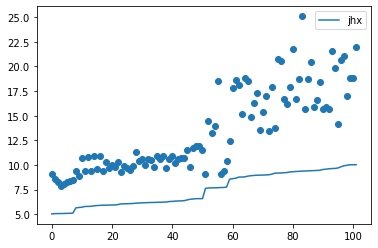

In [43]:
name = '2ev5'
obsec = np.loadtxt(f'ObsECs_{name}.txt')
#print(obsec)
obsdat = np.loadtxt(f'obs_{name}.txt')
#obstime  = np.loadtxt(f'fobs_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#earth-sun
#print(delta_N)
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
y = obsdat
nt = np.arange(len(d_N))
plt.scatter(nt,y)
#delta_N,d_N,alpha_N = x
'''for i in np.arange(100,2000,50):
    theta = [0.2,i]
    flux = Model_neatm_hhq(theta,x=(delta_N,d_N,alpha_N))
    flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N))
    print(i,flux[0],flux2[0])
for i in np.arange(0.1,2.4,0.1):
    theta = [i,456]
    flux = Model_neatm_hhq(theta,x=(delta_N,d_N,alpha_N))
    flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N))
    print(i,flux[0],flux2[0])'''
theta = [2.8,200]
flux = Model_neatm_hhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
#plt.plot(nt,flux,label = 'hhq')
plt.plot(nt,flux2,label = 'jhx')
print(flux2)
plt.legend()


## define MCMC_function

In [44]:
#initial
eta_gs = 1.2
D_gs = 400
eta_gss = [0.01,2.8]
D_gss = [1,500000]

In [45]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D= theta
    model = Model_neatm_jhx(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D = theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [46]:
#initial para guesses
eta = eta_gs
D = D_gs
theta = [eta, D]

In [47]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 1000, progress=True);

/tmp/ipykernel_827985/3011063627.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy
100%|██████████| 1000/1000 [18:31<00:00,  1.11s/it]


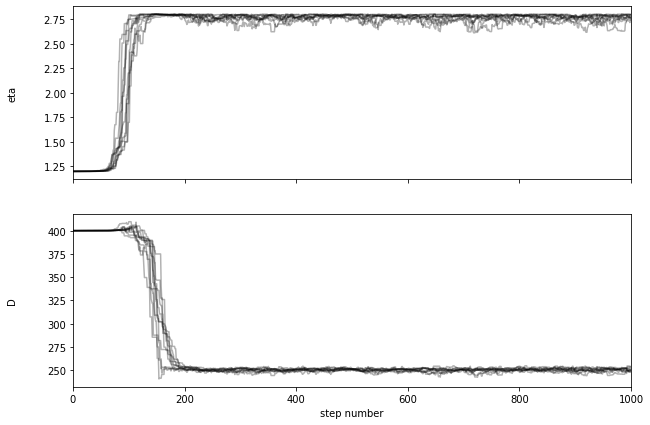

In [48]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

(260, 2)


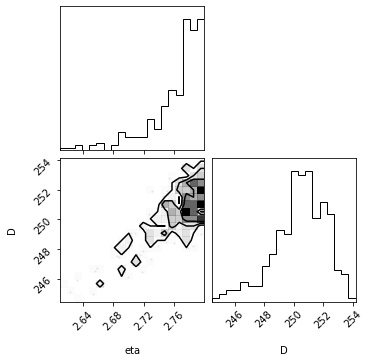

In [49]:
#--------------------------
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, 103816]
);

In [50]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  400 pv= 0.28144651206580884


/tmp/ipykernel_827985/3011063627.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy
/tmp/ipykernel_827985/3011063627.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy
/tmp/ipykernel_827985/3011063627.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy
/tmp/ipykernel_827985/301

eta_fit =  2.775086044781478 D_fit=  250.5111412688993


/tmp/ipykernel_827985/3011063627.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy


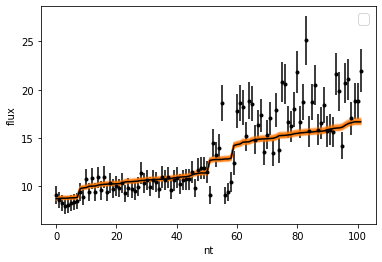

In [51]:
inds = np.random.randint(len(flat_samples), size=100)
#print(nt)
#print(len(flat_samples))
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plt.plot(nt, Model_neatm_jhx(sample,x,lamdai), "C1", alpha=0.1)
plt.errorbar(nt, y, yerr=yerr, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");

eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
print('eta_fit = ',eta_fit,'D_fit= ',D_fit)
theta = eta_fit,D_fit
yt = Model_neatm_jhx(theta,x,lamdai)
plt.plot(nt, yt,"k", label="Most")